# Normalized Inputs

Manipulate training data to have the outline pixels highlighted. Apply model on original testing dataset.

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.sampler as sampler
from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import network
import mnist_loader

train_loader, validation_loader, test_loader = mnist_loader.load_data(normalize=True)
_, _, test_loader_org = mnist_loader.load_data()

print(len(validation_loader.dataset))

torch.cuda.is_available()

10000


False

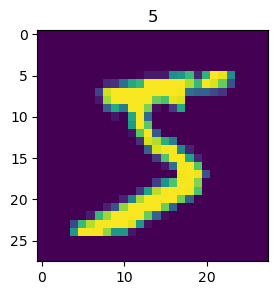

In [24]:
# outlined image

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.title(f"{train_loader.dataset[0][1]}")
plt.imshow(train_loader.dataset[0][0][0])
plt.show()

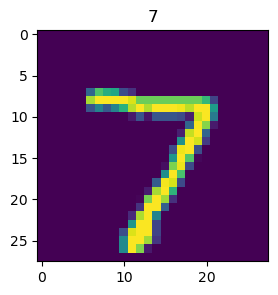

In [25]:
plt.figure(figsize=(3, 3))
plt.title(f"{test_loader_org.dataset[0][1]}")
plt.imshow(test_loader_org.dataset[0][0][0])
plt.show()

In [26]:
# model accuracy check
def accuracy(output, target):
    return sum([torch.argmax(o) == t for o, t in zip(output, target)]), len(target)

## Network 1
Simple network with 3 fully connected layers. Sigmoid activation function. Cross Entropy Loss function.

In [ ]:
eta = 0.3
epochs = 10

net1 = network.Network1()
print(net1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net1.parameters(), lr=eta)
net1.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net1.train() # training mode
        
        output = net1(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0: # for every 100th batch
            net1.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net1(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
    
    print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
    train_accs.append(total_acc)
    train_loss.append(total_loss / len(train_loader))

Network1(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 10.239999771118164
 evaluation accuracy: 11.420000076293945
 training accuracy: 11.02833366394043
epoch 1
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 9.199999809265137
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 10.600000381469727
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 training accuracy: 10.979999542236328
epoch 2
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 9.199999809265137
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evalua

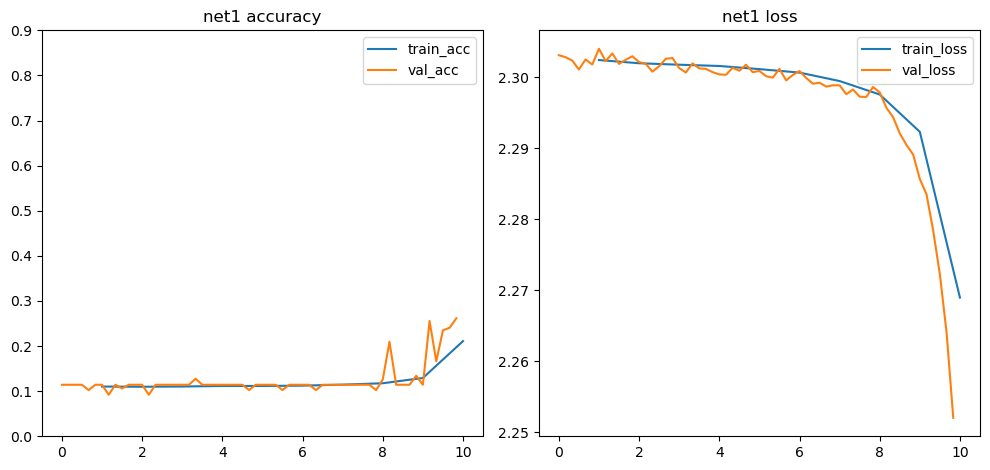

final loss: train 2.2689471451441445 v eval 2.252021074414253
final acc: train 0.210999995470047 v eval 0.26159998774528503


In [ ]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot(range(1, epochs+1), [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.0, .9)
ax[0].set_title('net1 accuracy')
ax[0].legend()

ax[1].plot(range(1, epochs+1), train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_title('net1 loss')
ax[1].legend()

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_loss[0]} v eval {final_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

performed slightly better than the non-negative equivalent.

In [ ]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net1(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 27.5


## Network 2
Network 1, but with ReLU activation instead of sigmoid.

In [27]:
eta = 0.1
epochs = 20

# Create a SummaryWriter instance
writer = SummaryWriter()

net2 = network.Network2()
print(net2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=eta)
net2.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []
grad_norms_fc1 = []
grad_norms_fc2 = []
grad_norms_fc3 = []

total_loss = 0.
total_acc = (0, 0)

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    for i, (X, y) in enumerate(train_loader):
        net2.train() # training mode
        
        output = net2(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        if i == len(train_loader) - 1:
            grad_norms_fc1.append(torch.norm(net2.fc1.weight.grad))
            grad_norms_fc2.append(torch.norm(net2.fc2.weight.grad))
            grad_norms_fc3.append(torch.norm(net2.fc3.weight.grad))
        
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 99: # for every 100th batch
            net2.eval() # evaluation mode
            
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net2(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
                
            print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
            train_accs.append(total_acc)
            train_loss.append(total_loss / 100)
                        
            # Log scalar values
            writer.add_scalars('Net2 Loss', {'train': total_loss / 100, 'val': total_val_loss / len(validation_loader)}, epoch * len(train_loader) + i)
            writer.add_scalars('Net2 Acc', {'train': total_acc[0] / total_acc[1], 'val': val_acc[0] / val_acc[1]}, epoch * len(train_loader) + i)
            
            total_loss = 0.
            total_acc = (0, 0)
    

Network2(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 55.900001525878906
 training accuracy: 48.0
 evaluation accuracy: 83.66000366210938
 training accuracy: 76.31999969482422
 evaluation accuracy: 84.30000305175781
 training accuracy: 85.13999938964844
 evaluation accuracy: 87.58000183105469
 training accuracy: 88.37000274658203
 evaluation accuracy: 87.58000183105469
 training accuracy: 89.48999786376953
 evaluation accuracy: 87.08000183105469
 training accuracy: 90.08000183105469
epoch 1
 evaluation accuracy: 88.66000366210938
 training accuracy: 91.12000274658203
 evaluation accuracy: 89.30000305175781
 training accuracy: 91.81999969482422
 evaluation accuracy: 89.62000274658203
 training accuracy: 92.26000213623047
 evaluation accuracy: 91.80000305175781
 training accuracy: 91.95999908447266
 evaluation accurac

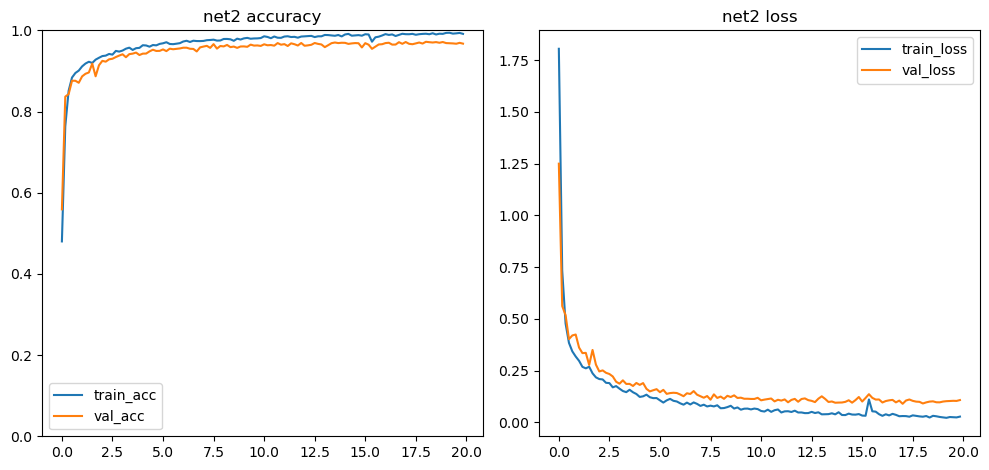

final loss: train 0.028142714929999785 v eval 0.10811545261066464
final acc: train 0.9912999868392944 v eval 0.967199981212616


In [28]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0., 1.)
ax[0].set_title('net2 accuracy')
ax[0].legend()

ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_title('net2 loss')
ax[1].legend()

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_loss[0]} v eval {final_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

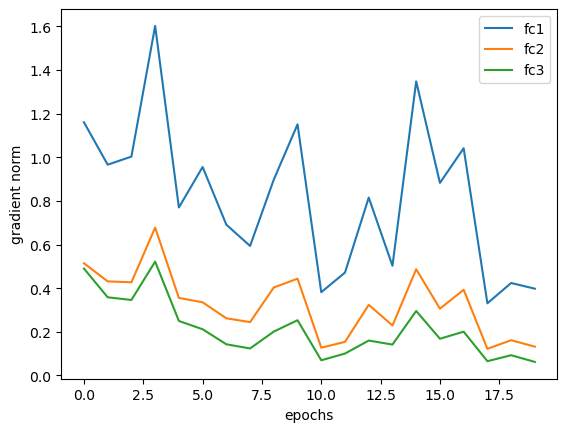

In [32]:
plt.plot(grad_norms_fc1, label='fc1')
plt.plot(grad_norms_fc2, label='fc2')
plt.plot(grad_norms_fc3, label='fc3')
plt.xlabel('epochs')
plt.ylabel('gradient norm')
plt.legend()
plt.show()

In [33]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net2(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 98.58000183105469


In [36]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader_org):
        # evaluation loss and accuracy check
        output = net2(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 89.4000015258789


Significantly better results when the model is trained on a normalized training dataset. The model works okay on the original testing dataset as well.

## Network 3
1 Convolutional layer, 2 fully connected layers.

In [13]:
eta = 0.1
epochs = 20
l2_lambda = 0.01
dropout = 0.2

# Create a SummaryWriter instance
writer = SummaryWriter()

net3 = network.Network3(dropout=dropout)
print(net3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net3.parameters(), lr=eta)
net3.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []
grad_norms_fc1 = []
grad_norms_fc2 = []
grad_norms_conv = []
    
total_loss = 0.
total_acc = (0, 0)

layers_to_regularize = [net3.conv, net3.fc1]

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net3.train() # training mode
        
        output = net3(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y))) # total_acc[0] + train_acc[0], total_acc[1] + train_acc[1]
        
        # l2 regularization
        l2_regularization = torch.tensor(0., requires_grad=True)
        for parameter in layers_to_regularize:
            l2_regularization = l2_regularization + torch.norm(parameter.weight, p=2) ** 2
        
        loss.backward()
        if i == len(train_loader) - 1:
            grad_norms_conv.append(torch.norm(net3.conv.weight.grad))
            grad_norms_fc1.append(torch.norm(net3.fc1.weight.grad))
            grad_norms_fc2.append(torch.norm(net3.fc2.weight.grad))
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 99: # for every 100th batch
            net3.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net3(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))

            print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
            train_accs.append(total_acc)
            train_loss.append(total_loss / 100)
                        
            # Log scalar values
            writer.add_scalars('Net2 Loss', {'train': total_loss / 100, 'val': total_val_loss / len(validation_loader)}, epoch * len(train_loader) + i)
            writer.add_scalars('Net2 Acc', {'train': total_acc[0] / total_acc[1], 'val': val_acc[0] / val_acc[1]}, epoch * len(train_loader) + i)
            
            total_loss = 0.
            total_acc = (0, 0)

Network3(
  (conv): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2880, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
epoch 0
 evaluation accuracy: 75.95999908447266
 training accuracy: 61.58000183105469
 evaluation accuracy: 89.94000244140625
 training accuracy: 87.16999816894531
 evaluation accuracy: 91.91999816894531
 training accuracy: 90.97000122070312
 evaluation accuracy: 93.72000122070312
 training accuracy: 93.31999969482422
 evaluation accuracy: 94.5999984741211
 training accuracy: 94.83000183105469
 evaluation accuracy: 95.33999633789062
 training accuracy: 95.05999755859375
epoch 1
 evaluation accuracy: 95.26000213623047
 training accuracy: 95.87000274658203
 evaluation accuracy: 95.68000030517578
 training accuracy: 96.36000061035156
 evaluation accuracy: 95.45999908447266
 training accuracy: 96.63999938964844
 evaluation accuracy: 96.63999938964844
 trai

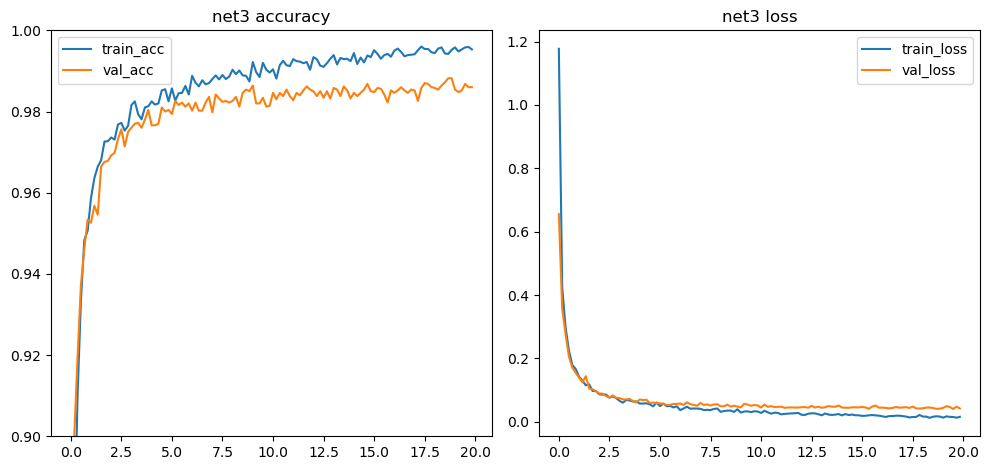

final loss: train 1.1774391838908196 v eval 0.42485310390591624
final acc: train 0.9952999949455261 v eval 0.9860000014305115


In [14]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.9, 1.)
ax[0].set_title('net3 accuracy')
ax[0].legend()

ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
# ax[1].set_ylim(0.0, 1.)
ax[1].set_title('net3 loss')

fig.set_figwidth(10)

plt.tight_layout()
plt.legend()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {train_loss[0]} v eval {train_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

More overfitting compared to training on original dataset. Perhaps the result of less activation of pixels and hence less information in the dataset.

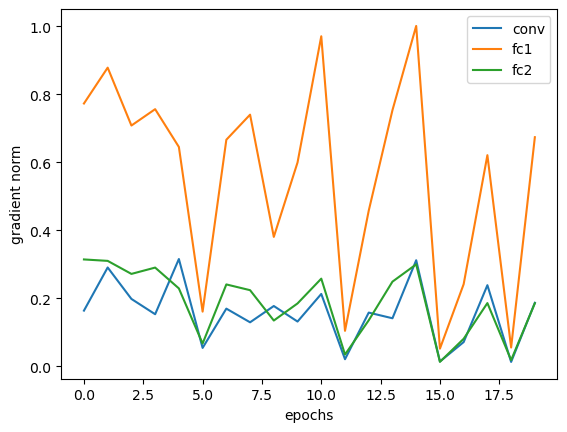

In [15]:
plt.plot(grad_norms_conv, label='conv')
plt.plot(grad_norms_fc1, label='fc1')
plt.plot(grad_norms_fc2, label='fc2')
plt.xlabel('epochs')
plt.ylabel('gradient norm')
plt.legend()
plt.show()

In [16]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader):
        # evaluation loss and accuracy check
        output = net3(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 99.63999938964844


Somewhat superior learning results when compared to training the model on the original dataset.

In [17]:
with torch.no_grad():
    test_acc = (0, 0)
    for j, (test_X, test_y) in enumerate(test_loader_org):
        # evaluation loss and accuracy check
        output = net2(test_X)
        test_acc = tuple(a + b for a, b in zip(test_acc, accuracy(output, test_y)))

print(f" test accuracy: {100 * test_acc[0] / test_acc[1]}")

 test accuracy: 97.63999938964844
